Set working directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

# Change file_path as necessary
file_path = "../Relevant data" 

os.chdir(file_path)

Load files

In [2]:
def identify_type_of_day(date):
    weekno = date.weekday()
    #Ignoring the major study breaks as this is not much importance
    #if((date.month == 7 and week_of_month(date) < 4 ) or (date.month == 12 or date.month == 1 or date.month == 2)):
    #    return 'Major_study_break'
    if weekno>4:
        return 'Weekend'
    elif is_public_holiday(date):
        return 'Public_holiday'
    else:
        return 'Normal_Weekday'

#Week of month
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#Returns True if it's  public holiday
def is_public_holiday(dt):
    #public_holiday file for year 2017, use API/ file having multiple year's records to apply for different years
    public_holidays =  pd.read_csv('australianpublicholidays.csv', sep=',', encoding='ISO-8859-1', parse_dates=['Date'],
                 date_parser=lambda x: pd.to_datetime(x))
    """"Instead API could be used : import urllib
    url = 'https://data.gov.au/api/3/action/datastore_search?resource_id=253d63c0-af1f-4f4c-b8d5-eb9d9b1d46ab&limit=5&q=title:jones'  
    fileobj = urllib.urlopen(url)
    print fileobj.read() """
    
    #get public holidays of SA only
    public_holidays_SA = public_holidays[public_holidays['Applicable To'].str.contains("SA") | public_holidays['Applicable To'].str.contains("NAT")]
    
    #Return True if each date is public holiday in SA
    return dt in (public_holidays_SA['Date'].apply(lambda x: datetime.date(x))).values


In [3]:
#reads a csv file, adds a day type column, creates a csv file with day type column and returns a dataframe object with day type
def add_day_type_column(file, date_column):
    data_file = pd.read_csv(file, sep=',', encoding='ISO-8859-1', parse_dates=[date_column],
                 date_parser=lambda x: pd.to_datetime(x.rsplit(' ', 1)[0]))
    data_file['Type_of_day'] = data_file[date_column].apply(lambda x: identify_type_of_day(datetime.date(x)))
    file_name = file + '_with_day_type.csv'
    #uncomment next line if you want a new file to be created with day type column
    #data_file.to_csv(file_name, sep=',', encoding='utf-8')
    return data_file


In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ### estimate campus power
# 
# The bulk of the data is for kVA values. Estimated the real power drawn from this based on the mean power factor for the data we did have. 

# In[8]:

def campus_power_estimation(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """
    
    #bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']

   #if logger.getEffectiveLevel() < logging.INFO: 
        #plt.scatter(bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'], 
         #           bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['kVA'], 
          #          alpha=0.05)
        #plt.title('Power factor scatter plot.'); 
        #plt.show()
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    #bms['kW_est'] = np.where(bms['kW'] == 0.0, bms['kW_est'], bms['kW'])
    return bms


In [5]:
#replace zero's with previous year values
def replace_zeros(bms,bms_lastyear):
    #replace year in timestamp
    imputed_df = bms.where((bms['kVA'] == 0) & (bms['TimeStamp'] == bms_lastyear['TimeStamp']), bms_lastyear['kVA'],axis=0)
    return imputed_df

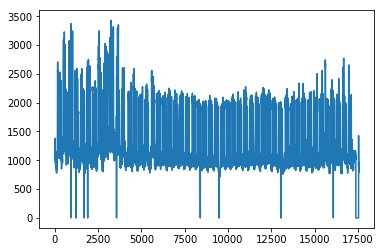

In [6]:
#2016 demand plotline
bms_demand_2016 = add_day_type_column("bms_2016_kva.csv",'?Timestamp')
bms_demand_2016.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2016['kVA'].plot.line()

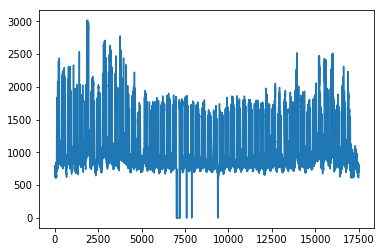

In [7]:
#read data file and add type of day column to it
bms_demand_2017 = add_day_type_column('bms_2017_kva.csv','?Timestamp')
bms_demand_2017.rename(columns={'ML_PH/Main_11kV_kW (kW)': 'kW','?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2017_est = campus_power_estimation(bms_demand_2017)
bms_demand_2017['kW_est'].plot.line()

#imputed kva's plot line (replaced from last year values)
#bms_2017_imputed = replace_zeros(bms_demand_2017, bms_demand_2016)
#bms_2017_imputed['kVA'].plot.line()

#Estimate kW using kVA if kW values not recorded
#bms_demand_2017_est = campus_power_estimation(bms_2017_imputed)
#bms_demand_2017_est['kW_est'].plot.line()


Text(0,0.5,'kW_est')

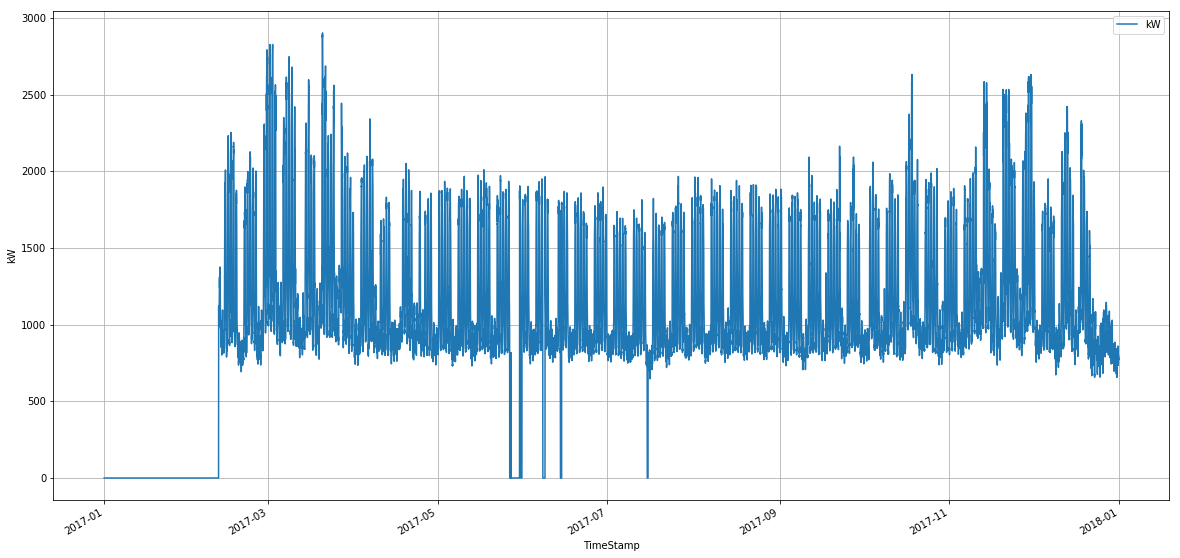

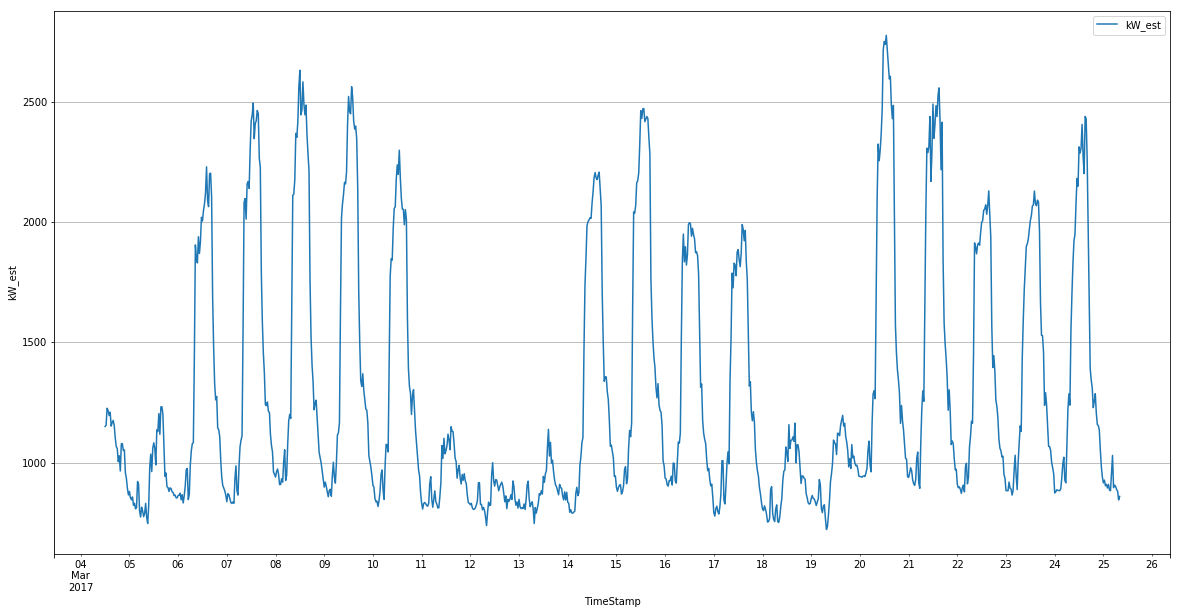

In [32]:
ax = bms_demand_2017.plot(x='TimeStamp', y='kW' ,figsize=(20,10), grid=True  )
ax.set_ylabel("kW")
ax1 = bms_demand_2017_est.loc[3000:4000].plot(x='TimeStamp', y='kW_est' ,figsize=(20,10), grid=True  )
ax1.set_ylabel("kW_est")

In [8]:
#construct data sets for years 2013 to 2017
bms_demand_201314 = add_day_type_column("bms_1314_kva.csv",'?Timestamp')
bms_demand_201314.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2015 = add_day_type_column("bms_2015_kva.csv",'?Timestamp')
bms_demand_2015.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)

In [9]:
bms_13to17_kva = pd.concat([bms_demand_2017,bms_demand_2016,bms_demand_2015,bms_demand_201314],sort = True)
bms_13to17_kva = bms_13to17_kva.sort_values('TimeStamp').reset_index()
bms_1317_kW_est = campus_power_estimation(bms_13to17_kva)
bms_1317_kW_est

,index,Humidity,ML_PH/Main_11kV_kW (kW),Temp,TimeStamp,Type_of_day,kVA,kW,kW_est
0,0,45,0.0,21.6,2013-01-01 00:00:00,Normal_Weekday,956.3,NaN,879.796
1,1,46,0.0,21.2,2013-01-01 00:30:00,Normal_Weekday,937.8,NaN,862.776
2,2,50,0.0,20.2,2013-01-01 01:00:00,Normal_Weekday,918.7,NaN,845.204
3,3,52,0.0,18.7,2013-01-01 01:30:00,Normal_Weekday,913.0,NaN,839.960
4,4,50,0.0,18.5,2013-01-01 02:00:00,Normal_Weekday,900.7,NaN,828.644
5,5,47,0.0,18.4,2013-01-01 02:30:00,Normal_Weekday,921.8,NaN,848.056
6,6,46,0.0,18.2,2013-01-01 03:00:00,Normal_Weekday,923.7,NaN,849.804
7,7,46,0.0,18.0,2013-01-01 03:30:00,Normal_Weekday,929.3,NaN,854.956
8,8,46,0.0,17.3,2013-01-01 04:00:00,Normal_Weekday,939.5,NaN,864.340
9,9,49,0.0,16.9,2013-01-01 04:30:00,Normal_Weekday,927.0,NaN,852.840


In [10]:
bms_1317_kW_est.to_csv("bms_13to17_kW_est.csv", sep=',', encoding='utf-8')

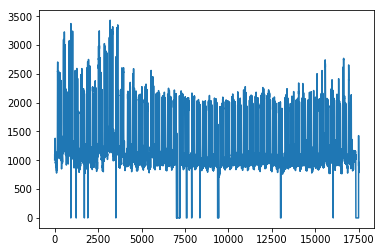

In [11]:
#test code for imputation
test_2017 = bms_demand_2017
test_2016 = bms_demand_2016
#bms_demand_2017.where(bms_demand_2017['kVA'] != 0 && bms_demand_2017['TimeStamp'].apply(lambda x: datetime.date(x)) 
 #                     , bms_demand_2016['kVA'],axis=0)
test_2016_without_29 = test_2016.drop(test_2016[(test_2016['TimeStamp'] >= '2016-02-29 00:00:00') & (test_2016['TimeStamp'] < '2016-03-01 00:00:00')].index).reset_index()
test_2017.sort_index(inplace=True)
test_2016_without_29['TimeStamp'] = test_2016_without_29['TimeStamp'].apply(lambda x: x.replace(year = 2017))
df_without_zero = replace_zeros(test_2017,test_2016_without_29)

df_without_zero.kW_est.plot()

Text(0,0.5,'Average daily kW')

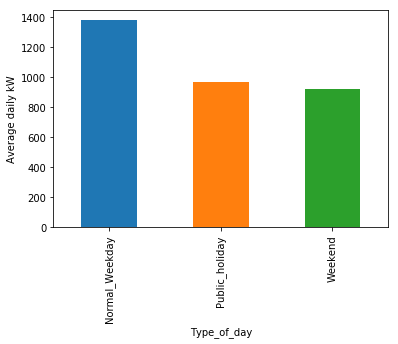

In [33]:
# Distribution of consumption during different day type's
grouped_by_daytype = bms_1317_kW_est.groupby(['Type_of_day'])['kW_est'].mean()
grouped_by_daytype
ax = grouped_by_daytype.plot.bar()
ax.set_ylabel("Average daily kW")

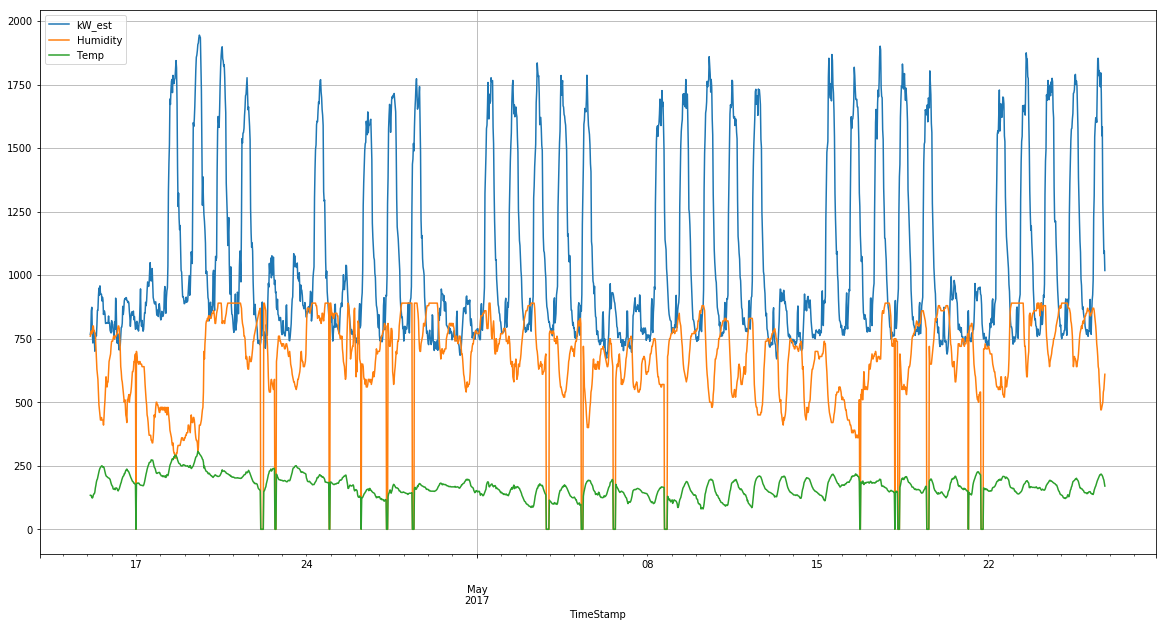

In [13]:
# change scale of humidity and temperature
bms_transformed = bms_demand_2017_est[['TimeStamp','kW_est', 'Type_of_day','Humidity','Temp']].copy()
bms_transformed['Humidity'] = bms_transformed['Humidity'].apply(lambda x: x*10)
bms_transformed['Temp'] = bms_transformed['Temp'].apply(lambda x: x*10)
bms_transformed.loc[5000:7000].plot(x='TimeStamp', y=['kW_est','Humidity','Temp'] ,figsize=(20,10), grid=True  )

                            index  Humidity  ML_PH/Main_11kV_kW (kW)  \
index                    1.000000  0.006215                      NaN   
Humidity                 0.006215  1.000000                      NaN   
ML_PH/Main_11kV_kW (kW)       NaN       NaN                      NaN   
Temp                    -0.095654 -0.701591                      NaN   
kVA                     -0.021564 -0.295842                      NaN   
kW                       0.342317 -0.130496                      NaN   
kW_est                  -0.021564 -0.295842                      NaN   

                             Temp       kVA        kW    kW_est  
index                   -0.095654 -0.021564  0.342317 -0.021564  
Humidity                -0.701591 -0.295842 -0.130496 -0.295842  
ML_PH/Main_11kV_kW (kW)       NaN       NaN       NaN       NaN  
Temp                     1.000000  0.436290  0.080648  0.436290  
kVA                      0.436290  1.000000  0.619806  1.000000  
kW                       0.

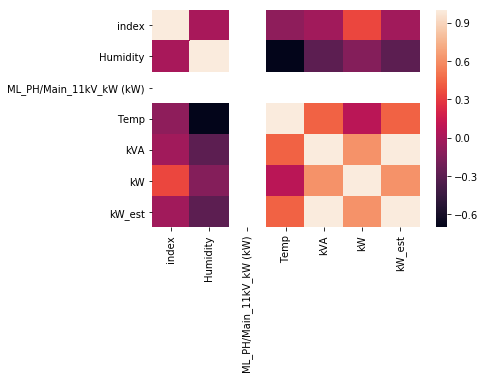

In [14]:
#Check correations among attributes
corr_val = bms_1317_kW_est.corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)

In [15]:
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults

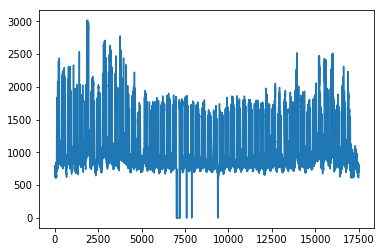

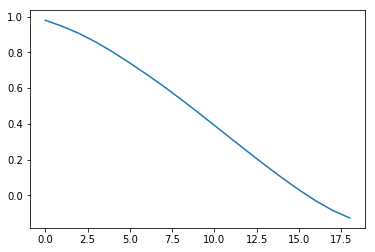

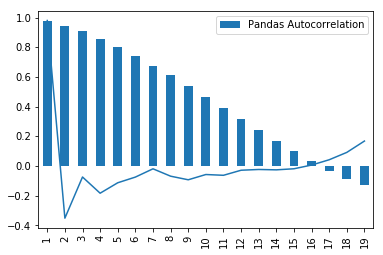

(-19.15818203840026,
 0.0,
 1,
 17518,
 {'1%': -3.4307233450435692,
  '5%': -2.8617050041000534,
  '10%': -2.5668578273974973},
 204070.75591470476)

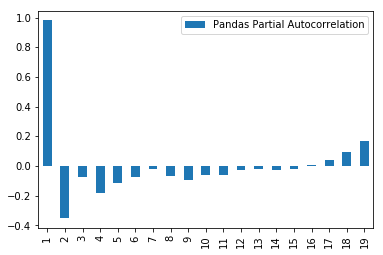

In [16]:
demand = bms_demand_2017_est['kW_est']

plt.plot(demand)
plt.show()
acf_1 =  acf(demand)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(demand)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(demand, 1)
result

In [17]:
demand_matrix=demand.as_matrix()
model = ARIMA(demand_matrix, order=(3,1,3))
model_fit = model.fit(disp=0)
fits = model_fit.fittedvalues
residuals = model_fit.resid
print(model_fit.summary())
#predictions = model_fit.predict(2,17600, typ = 'levels')
#predictions
#predictionsadjusted = np.exp(predictions)
#plt.plot(predictionsadjusted)
#plt.show()

#model_fit.plot_diagnostics(figsize=(15, 12))

C:\Users\MeAmit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                17519
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -101921.788
Method:                       css-mle   S.D. of innovations             81.356
Date:                Mon, 22 Oct 2018   AIC                         203859.575
Time:                        14:45:49   BIC                         203921.744
Sample:                             1   HQIC                        203880.046
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      1.288      0.002      0.998      -2.522       2.528
ar.L1.D.y      0.7928      0.053     14.829      0.000       0.688       0.898
ar.L2.D.y     -0.4234      0.090     -4.702      0.0

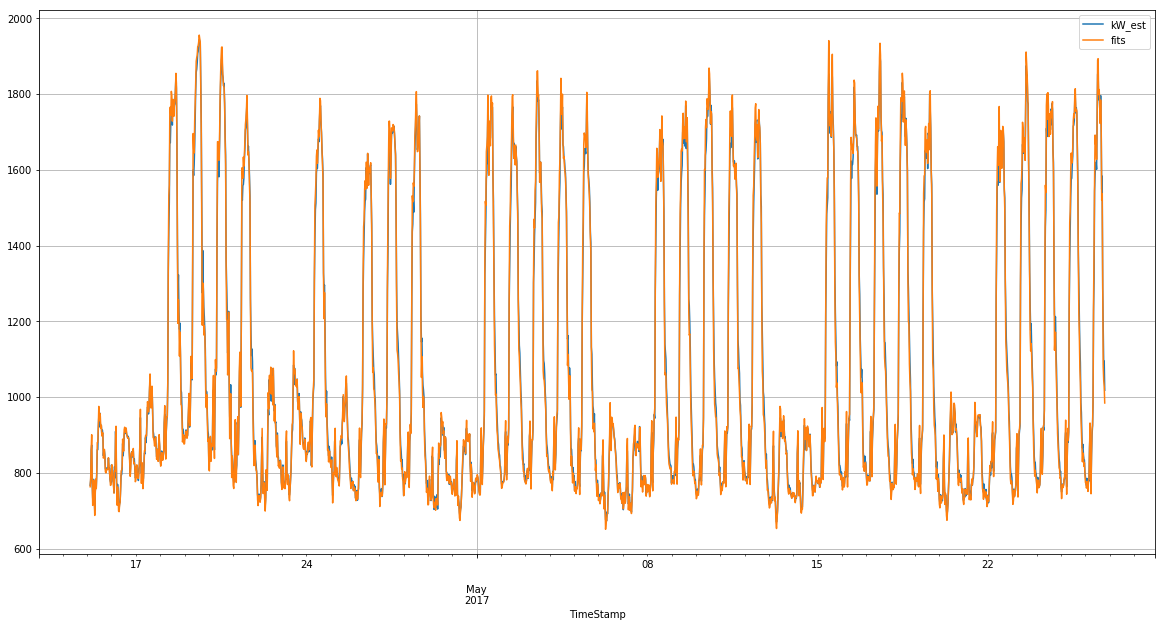

In [18]:
#results = ARMAResults(model,predictions)
#fittedValues = results.fittedvalues
#append 0 in first element
fits = np.concatenate([[0],fits])
bms_demand_2017_est['fits'] = bms_demand_2017_est['kW_est'] + fits
bms_demand_2017_est.loc[5000:7000].plot(x='TimeStamp', y=['kW_est','fits'] ,figsize=(20,10), grid=True  )

In [19]:
#ARIMAX model
arimax_model=ARIMA(endog=bms_demand_2017_est['kW_est'],exog=bms_demand_2017_est[['Temp','Humidity']],order=[3,1,3])
results3=arimax_model.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.kW_est   No. Observations:                17519
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -101888.017
Method:                       css-mle   S.D. of innovations             81.200
Date:                Mon, 22 Oct 2018   AIC                         203796.035
Time:                        14:46:03   BIC                         203873.745
Sample:                             1   HQIC                        203821.623
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -13.6495      6.950     -1.964      0.050     -27.271      -0.028
Temp              -0.5502      0.202     -2.719      0.007      -0.947      -0.154
Humidity           0.3715      0.066

In [20]:
# Future fits
current_values = bms_demand_2017_est.fits[17500:]
forecast = model_fit.predict(start=17500, end=17600)
print(bms_demand_2017_est.fits[17500:])
print(forecast)
#bms_demand_2017_est.insert(17500:17600, 'fits', forecast)


17500    782.168403
17501    769.001045
17502    769.287597
17503    782.153222
17504    785.824196
17505    819.242070
17506    769.083184
17507    725.844481
17508    704.639916
17509    681.626991
17510    695.532829
17511    694.392072
17512    689.555784
17513    732.527703
17514    772.797858
17515    774.203449
17516    763.284671
17517    741.625436
17518    725.685805
17519    729.069797
Name: fits, dtype: float64
[ 4.44403421e-01  8.43704503e+00 -7.19240319e+00  9.16922194e+00
 -3.98039365e-02  4.12206956e+00  9.16318362e+00 -1.44795186e+01
 -1.46008363e+00 -1.40770093e+01 -1.02911711e+01 -3.70392812e+00
 -6.24021557e+00 -7.12297450e-01  1.08538580e+01  7.65944900e+00
  5.48067085e+00  4.24543623e+00 -2.49419491e+00 -3.43420309e+00
 -2.06666525e+00 -3.39152132e+00 -1.31197041e+00 -2.37906989e-01
 -6.73677798e-01 -8.35276071e-01 -4.49049431e-01 -2.08246614e-01
 -2.30481487e-01 -2.31451122e-01 -1.48854890e-01 -8.97882577e-02
 -7.82264446e-02 -6.87023711e-02 -4.79070386e-02 -3.1

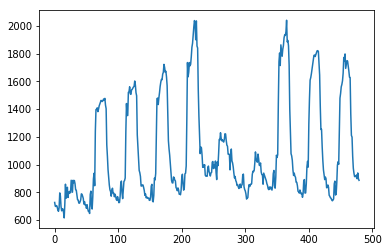

In [21]:
#validation data set
validation_2018 = add_day_type_column('validation_2018_data.csv','?Timestamp')
validation_2018.rename(columns={'ML_PH/Main_11kV_kW (kW)': 'kW','?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
validation_2018_est = campus_power_estimation(validation_2018)
validation_2018_est.to_csv("validation_2018_est.csv", sep=',', encoding='utf-8')
validation_2018_est.kW_est.plot()

In [22]:
validation_2018_est

,TimeStamp,kVA,kW,Humidity,Temp,Type_of_day,kW_est
0,2018-01-01 00:00:00,790.8,771.0,77,19.2,Public_holiday,727.536
1,2018-01-01 00:30:00,761.0,741.2,76,19.1,Public_holiday,700.120
2,2018-01-01 01:00:00,759.3,744.8,75,18.8,Public_holiday,698.556
3,2018-01-01 01:30:00,766.8,738.8,75,18.8,Public_holiday,705.456
4,2018-01-01 02:00:00,755.3,736.2,76,18.5,Public_holiday,694.876
5,2018-01-01 02:30:00,731.0,715.3,76,18.2,Public_holiday,672.520
6,2018-01-01 03:00:00,721.5,706.7,76,18.2,Public_holiday,663.780
7,2018-01-01 03:30:00,750.3,733.7,76,18.4,Public_holiday,690.276
8,2018-01-01 04:00:00,865.7,844.8,76,18.5,Public_holiday,796.444
9,2018-01-01 04:30:00,842.2,826.0,75,18.7,Public_holiday,774.824
